<a href="https://colab.research.google.com/github/majodomenech/neuralnetworks/blob/main/REDES_trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red neuronal autoencoder convolucional de varias capas


In [ ]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [ ]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

from torch.utils.data import Dataset, DataLoader, Subset, random_split

In [ ]:
import torch
import torch.optim as optim

from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms

from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

In [ ]:
torch.__version__

'2.1.0+cu121'

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
import google.colab
from google.colab import files
from google.colab import drive
# Monta tu Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# implementacion

In [ ]:
#descargamos datasets


# Download training data from open datasets.
training_data_original = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)


# Download test data from open datasets.
test_data_original = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12044125.70it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198991.31it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3719213.60it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24343040.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(training_data_original), len(test_data_original)

(60000, 10000)

In [ ]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder

class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return input,output

In [ ]:
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(training_data_original)
valid_set = CustomDataset(test_data_original)

In [ ]:
len(train_set), len(valid_set)

(60000, 10000)

# *modelo juan

In [ ]:
#definimos el modelo

class Autoencoder_conv(nn.Module):
    def __init__(self,n,p=0.2):
        super().__init__()

        self.encoder = nn.Sequential(
            #convolución1
            nn.Conv2d(1,16,kernel_size=3,padding=0),   # (1,28,28) -> (16,26,26)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (16,26,26) -> (16,13,13)

            #convolución2
            nn.Conv2d(16,32,kernel_size=3,padding=0),   # (16,13,13) -> (32,11,11)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (32,11,11) -> (32,5,5)

            #lineal
            nn.Flatten(1,3), # (32,5,5) -> (32*5*5)=(800)
            nn.Linear(32*5*5,n),  # fully conected (16*13*13) -> (n)
            nn.ReLU(),
            nn.Dropout(p),
            )

        self.decoder = nn.Sequential(
            #lineal
            nn.Linear(n,32*5*5),   # fully conected  (n) -> (32*5*5)
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1,(32,5,5)),  # (32*5*5) -> (32,5,5)

            #convolucion transpuesta2
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,output_padding=1),  # (32,5,5) -> (16,13,13)
            nn.ReLU(),
            nn.Dropout(p),

            #convolución transpuesta1
            nn.ConvTranspose2d(16,1,kernel_size=3,stride=2,output_padding=1),  # (16,13,13) -> (1,28,28)
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(p),
            )

    def forward(self, x):
        x = self.encoder(x)
        logits = self.decoder(x)
        return logits

# *modelo mio

In [ ]:

class AutoencoderConv(nn.Module):
    def __init__(self,n,p=0.2):
        super().__init__()

        #ENCODER
        #capa1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=0),   # (1,28,28) -> (16,26,26)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (16,26,26) -> (16,13,13)
            )
        #capa2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0),   # (16,13,13) -> (32,11,11)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (32,11,11) -> (32,5,5)
        )
        #capa3
        self.fc1 = nn.Sequential(
            #nn.Flatten(0,2), # (32,5,5) -> (32*5*5)=(800)
            nn.Flatten(1,3), # (32,5,5) -> (32*5*5)=(800)
            nn.Linear(32*5*5,n),  # fully conected (16*13*13) -> (n)
            nn.ReLU(),
            nn.Dropout(p),
            )

        #DECODER
        #capa4
        self.fc2 = nn.Sequential(
            nn.Linear(n,32*5*5),   # fully conected  (n) -> (32*5*5)
            nn.ReLU(),
            nn.Dropout(p),
            #nn.Unflatten(0,(32,5,5)),  # (32*5*5) -> (32,5,5)
            nn.Unflatten(1,(32,5,5)),  # (32*5*5) -> (32,5,5)
            )
        #capa5
        self.convT2 = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,output_padding=1),  # (32,5,5) -> (16,13,13)
            nn.ReLU(),
            nn.Dropout(p)
            )

        #capa6
        #original_size = [16, 13, 13]  # Tamaño original del tensor
        #target_size = [1, 28, 28]  # Tamaño objetivo del tensor
        #factor_h = target_size[1] // original_size[1] # Calcula el factor de aumento en cada dimensión
        #factor_w = target_size[2] // original_size[2]

        #self.convT1 = nn.Sequential(
        #    nn.ConvTranspose2d(in_channels=original_size[0],  # Número de canales en la entrada
        #                      out_channels=target_size[0],   # Número de canales en la salida
        #                      kernel_size=(factor_h, factor_w),  # Tamaño del kernel
        #                      stride=(factor_h, factor_w),       # Stride
        #                      padding=0,                         # Padding
        #                      output_padding=0,                  # Padding en la salida
        #                      ), # (16,13,13) -> (1,28,28)
        #    #nn.ReLU(),
        #    nn.Sigmoid(),
        #    nn.Dropout(p),
        #    )


        #capa6 (anterior)
        self.convT1 = nn.Sequential(
            nn.ConvTranspose2d(16,1,kernel_size=4,stride=2,output_padding=0),  # (16,13,13) -> (1,28,28)
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(p),
            )


    def forward(self, x):
        #print(f'antes de entrar: {x.shape}')
        x = self.conv1(x)
        #print(f'despues de la conv1: {x.shape}')
        x = self.conv2(x)
        #print(f'despues de la conv2: {x.shape}')
        x = self.fc1(x)
        #print(f'despues de la lineal1: {x.shape}')
        x = self.fc2(x)
        #print(f'despues de la lineal2: {x.shape}')
        x = self.convT2(x)
        #print(f'despues de la convTransp1: {x.shape}')

        #print('calculo factor_h y factor_w')
        #original_size = [16, 13, 13]  # Tamaño original del tensor
        #target_size = [1, 28, 28]  # Tamaño objetivo del tensor
        #factor_h = target_size[1] // original_size[1] # Calcula el factor de aumento en cada dimensión
        #factor_w = target_size[2] // original_size[2]

        #print(factor_h,factor_w)

        logits = self.convT1(x)
        #print(f'despues de la convTransp2: {logits.shape}')
        return logits

In [ ]:

class AutoencoderConv_SIN_LINEAL(nn.Module):
    def __init__(self,p=0.2):
        super().__init__()

        #ENCODER
        #capa1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=0),   # (1,28,28) -> (16,26,26)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (16,26,26) -> (16,13,13)
            )
        #capa2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0),   # (16,13,13) -> (32,11,11)
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2),  # (32,11,11) -> (32,5,5)
        )
        #capa3
        #self.fc1 = nn.Sequential(
        #    #nn.Flatten(0,2), # (32,5,5) -> (32*5*5)=(800)
        #    nn.Flatten(1,3), # (32,5,5) -> (32*5*5)=(800)
        #    nn.Linear(32*5*5,n),  # fully conected (16*13*13) -> (n)
        #    nn.ReLU(),
        #    nn.Dropout(p),
        #    )

        #DECODER
        #capa4
        #self.fc2 = nn.Sequential(
        #    nn.Linear(n,32*5*5),   # fully conected  (n) -> (32*5*5)
        #    nn.ReLU(),
        #    nn.Dropout(p),
        #    #nn.Unflatten(0,(32,5,5)),  # (32*5*5) -> (32,5,5)
        #    nn.Unflatten(1,(32,5,5)),  # (32*5*5) -> (32,5,5)
        #    )
        #capa5
        self.convT2 = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,output_padding=1),  # (32,5,5) -> (16,13,13)
            nn.ReLU(),
            nn.Dropout(p)
            )

        #capa6 (anterior)
        self.convT1 = nn.Sequential(
            nn.ConvTranspose2d(16,1,kernel_size=4,stride=2,output_padding=0),  # (16,13,13) -> (1,28,28)
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(p),
            )


    def forward(self, x):
        #print(f'antes de entrar: {x.shape}')
        x = self.conv1(x)
        #print(f'despues de la conv1: {x.shape}')
        x = self.conv2(x)
        #print(f'despues de la conv2: {x.shape}')
        x = self.convT2(x)
        #print(f'despues de la convTransp1: {x.shape}')

        #print('calculo factor_h y factor_w')
        #original_size = [16, 13, 13]  # Tamaño original del tensor
        #target_size = [1, 28, 28]  # Tamaño objetivo del tensor
        #factor_h = target_size[1] // original_size[1] # Calcula el factor de aumento en cada dimensión
        #factor_w = target_size[2] // original_size[2]

        #print(factor_h,factor_w)

        logits = self.convT1(x)
        #print(f'despues de la convTransp2: {logits.shape}')
        return logits

In [ ]:
#list_parametros = list(model.parameters())

#list_parametros

In [ ]:
#named_parameters_generator = model.named_parameters()

# Itera sobre los nombres, dimensiones y los parámetros
#for name, param in named_parameters_generator:
#    print(f"Nombre del parámetro: {name}")
#    print(f"Dimensión del parámetro: {param.shape}")
#    #print(f"Valor del parámetro: {param}")
#    print("-" * 30)

# grafico imagenes con modelo sin entrenar

In [ ]:
def batch(x):
  return x.unsqueeze(0)   # (1,28,28) -> (28,28)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy()  # (28,28) -> (1,28,28)

In [ ]:
n=64

model = Autoencoder_conv(n)    #modelo juan
#model = AutoencoderConv(n)      #modelo mio
#model = autoEncoder()     #modelo andrés

model = model.to('cpu')

#print(model,device)

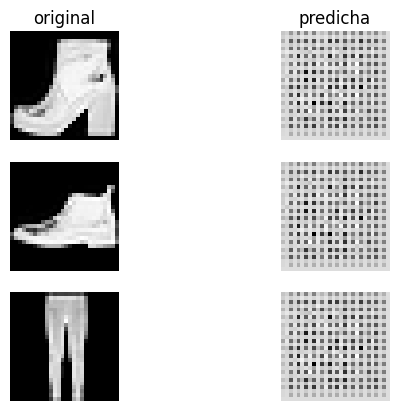

In [ ]:
figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')
plt.show()


In [ ]:
n=64

#model = Autoencoder_conv(n)    #modelo juan
model = AutoencoderConv(n)      #modelo mio
#model = autoEncoder()     #modelo andrés


model = model.to('cpu')

#print(model,device)

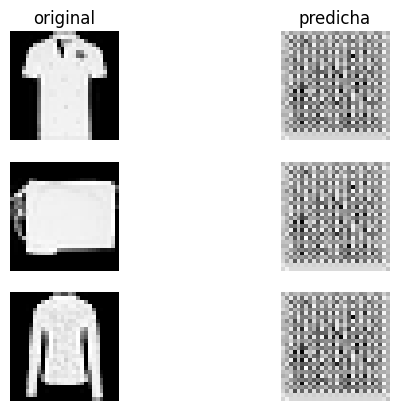

In [ ]:
figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')
plt.show()


In [ ]:
n=64

#model = Autoencoder_conv(n)    #modelo juan
#model = AutoencoderConv(n)      #modelo mio
model = autoEncoder()     #modelo andrés


model = model.to('cpu')

#print(model,device)

NameError: ignored

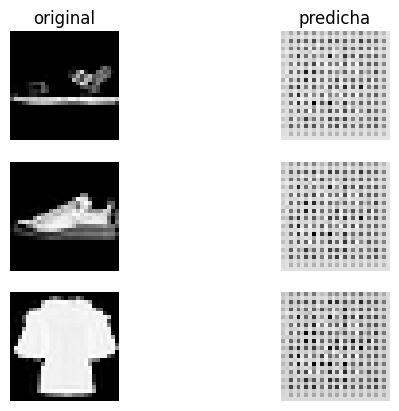

In [ ]:
figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')
plt.show()

#def loops de entrenamiento y validac

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=10):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)       #da 50000 para train_set y 10000 para valid_set
    num_minibatches = len(dataloader)    #son 50 si hay 1000 ejemplos en cada minibatch para train_set, son 10 para valid_set

    sum_loss,sum_correct = 0,0
    loss_value_de_cada_ejemplo = []

    # Iteramos sobre lotes (minibatchs)
    for minibatch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador provisto
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value          #aca se calcula la suma de los errores de todo el minibatch, para luego dividir por la cantidad de ej en el minibatch y tener la perdida promedio en ese minibatch

        loss_value_de_cada_ejemplo.append(loss.item())  #aca guardo el loss de cada MINIBATCH para ver si despues ploteo una nube de ruido

        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        # sum_correct += (pred == y).type(torch.float).sum().item()

        #if minibatch % verbose_each == 0:     #va a dar true solamente para el minibatch numero 0 (el primero de la epoca)
            #current = (minibatch+1)*len(X)
            #print(f"@train_loop minibatch={minibatch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")

    avg_loss = sum_loss/num_minibatches
    #precision = sum_correct/size

    return avg_loss,loss_value_de_cada_ejemplo#,precision

In [ ]:
# De manera similar, definimos la función de validación
def valid_loop(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_minibatches = len(dataloader)

    sum_loss,sum_correct = 0,0
    loss_value_de_cada_ejemplo=[]

    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (minibatches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()

            loss_value_de_cada_ejemplo.append(loss_fn(pred,y).item())

            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred == y).type(torch.float).sum().item()

    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_minibatches
    #precision = sum_correct/size
    #print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    print(f"avg_loss={avg_loss:>8f}")
    return avg_loss,loss_value_de_cada_ejemplo#,precision

In [ ]:
# Creamos los DataLoaders
minibatch_size = 100    #tamaño minibatchs
train_loader = DataLoader(train_set, batch_size=minibatch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=minibatch_size,shuffle=True)

In [ ]:
len(train_loader), len(valid_loader) #el primero tiene 50 minibatchs de 1000 ejemplos, el segundo 10 minibatchs de 1000 ejemplos

(600, 100)

In [ ]:
len(train_loader.dataset)

60000

In [ ]:
# Creamos una instancia de una función de pérdida, (Mean Squared Error, MSE) en PyTorch, puedes utilizar la clase nn.MSELoss.

loss_fn = nn.MSELoss()

# ---Entrenando autoencoder juan n=64 p=0.2 ADAM MSE

In [ ]:
n=64

model = Autoencoder_conv(n)
#model = AutoencoderConv(n)
#model = autoEncoder(n)

model = model.to(device)

#print(model,device)

In [ ]:
# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.

num_epochs = 50

list_train_avg_loss_incorrecta_64 = []
list_train_avg_loss_64 = []
list_valid_avg_loss_64 = []
#list_train_precision_incorrecta = []
#list_train_precision = []
#list_valid_precision = []

list_train_loss_incorrecta_cada_ej_64 = []
list_train_loss_cada_ej_64 = []
list_valid_loss_cada_ej_64 = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta_64,train_loss_incorrecta_cada_ej_64 = train_loop(train_loader,model,loss_fn,optimizer)
    train_avg_loss_64,train_loss_cada_ej_64 = valid_loop(train_loader,model,loss_fn)
    valid_avg_loss_64,valid_loss_cada_ej_64 = valid_loop(valid_loader,model,loss_fn)

    list_train_avg_loss_incorrecta_64.append(train_avg_loss_incorrecta_64)
    list_train_avg_loss_64.append(train_avg_loss_64)
    list_valid_avg_loss_64.append(valid_avg_loss_64)

    list_train_loss_incorrecta_cada_ej_64.append(train_loss_incorrecta_cada_ej_64)
    list_train_loss_cada_ej_64.append(train_loss_cada_ej_64)
    list_valid_loss_cada_ej_64.append(valid_loss_cada_ej_64)

print("Done!")

Epoch 1
-------------------------------
avg_loss=0.059931
avg_loss=0.059926
Epoch 2
-------------------------------
avg_loss=0.054767
avg_loss=0.054800
Epoch 3
-------------------------------
avg_loss=0.055356
avg_loss=0.055375
Epoch 4
-------------------------------
avg_loss=0.054863
avg_loss=0.054882
Epoch 5
-------------------------------
avg_loss=0.054593
avg_loss=0.054608
Epoch 6
-------------------------------
avg_loss=0.052700
avg_loss=0.052715
Epoch 7
-------------------------------
avg_loss=0.052212
avg_loss=0.052241
Epoch 8
-------------------------------
avg_loss=0.051381
avg_loss=0.051416
Epoch 9
-------------------------------
avg_loss=0.051825
avg_loss=0.051871
Epoch 10
-------------------------------
avg_loss=0.051516
avg_loss=0.051561
Epoch 11
-------------------------------
avg_loss=0.052522
avg_loss=0.052568
Epoch 12
-------------------------------
avg_loss=0.051059
avg_loss=0.051102
Epoch 13
-------------------------------
avg_loss=0.052835
avg_loss=0.052890
Epoch 14

## guardo y cargo

In [ ]:
#aca guardo las listas con los loss para poder graficar

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_64_ADAM_50epoch.npy', list_train_avg_loss_incorrecta_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_64_ADAM_50epoch.npy', list_train_avg_loss_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_64_ADAM_50epoch.npy', list_valid_avg_loss_64)

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_64_ADAM_50epoch.npy', list_train_loss_incorrecta_cada_ej_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_64_ADAM_50epoch.npy', list_train_loss_cada_ej_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_64_ADAM_50epoch.npy', list_valid_loss_cada_ej_64)

In [ ]:
# Save the general checkpoint (luego de tener el modelo ya entrenado)

# Collect all relevant information and build your dictionary.


# Additional information
EPOCH = 50
PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_64_ADAM_50epoch.pt'
LOSS = 0.054155

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

n=64

model =  Autoencoder_conv(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_64_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model = model.to(device)

In [ ]:
#64
list_train_avg_loss_incorrecta_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_64_ADAM_50epoch.npy')
list_train_avg_loss_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_64_ADAM_50epoch.npy')
list_valid_avg_loss_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_64_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_64_ADAM_50epoch.npy')
list_train_loss_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_64_ADAM_50epoch.npy')
list_valid_loss_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_64_ADAM_50epoch.npy')

## grafico loss

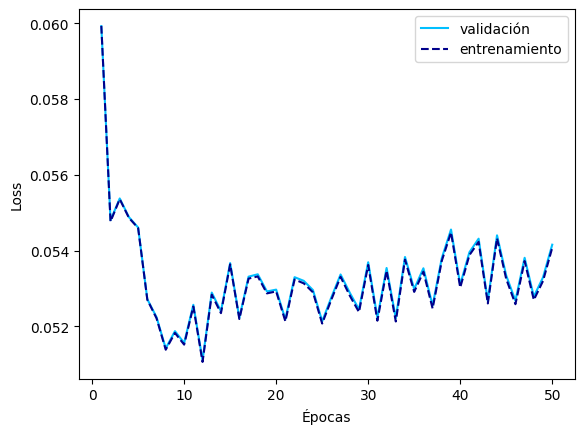

In [ ]:
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)


#plt.plot(range(1,len(list_train_avg_loss)+1),list_train_loss_cada_ej,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_64)+1),list_valid_loss_cada_ej_64,c='lightgreen')#,lw=0.5)


#plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1),list_train_avg_loss_incorrecta,label="train-incorr",linestyle='-',c='red')

plt.plot(range(1,len(list_valid_avg_loss_64)+1),list_valid_avg_loss_64,label="validación",linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss_64)+1),list_train_avg_loss_64,label="entrenamiento",linestyle='--',c='darkblue')

#plt.xlim(0,100)

#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_autoencoder_juan_64_02_ADAM_50epoch.png", dpi =300)

plt.title('')
plt.legend()

## grafico imagenes originales vs predichas

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

model = Autoencoder_conv(n=64)
learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-3/modelo_64_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

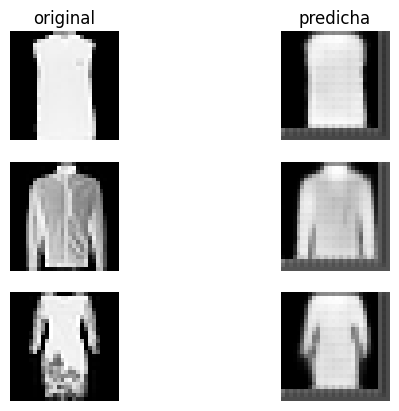

In [ ]:
model = model.to('cpu')

figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')


#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_prediccion_autoencoder_juan_64_02_ADAM_50epoch_2.png", dpi =300)

plt.show()

# ---Entrenando autoencoder conv sin capa lineal p=0.2 ADAM


In [ ]:
n=64

#model = Autoencoder_conv(n)
#model = AutoencoderConv(n)
#model = autoEncoder(n)
model = AutoencoderConv_SIN_LINEAL()

model = model.to(device)

#print(model,device)

In [ ]:
# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.

num_epochs = 50

list_train_avg_loss_incorrecta_SINL = []
list_train_avg_loss_SINL = []
list_valid_avg_loss_SINL = []
#list_train_precision_incorrecta = []
#list_train_precision = []
#list_valid_precision = []

list_train_loss_incorrecta_cada_ej_SINL = []
list_train_loss_cada_ej_SINL = []
list_valid_loss_cada_ej_SINL = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta_SINL,train_loss_incorrecta_cada_ej_SINL = train_loop(train_loader,model,loss_fn,optimizer)
    train_avg_loss_SINL,train_loss_cada_ej_SINL = valid_loop(train_loader,model,loss_fn)
    valid_avg_loss_SINL,valid_loss_cada_ej_SINL = valid_loop(valid_loader,model,loss_fn)

    list_train_avg_loss_incorrecta_SINL.append(train_avg_loss_incorrecta_SINL)
    list_train_avg_loss_SINL.append(train_avg_loss_SINL)
    list_valid_avg_loss_SINL.append(valid_avg_loss_SINL)

    list_train_loss_incorrecta_cada_ej_SINL.append(train_loss_incorrecta_cada_ej_SINL)
    list_train_loss_cada_ej_SINL.append(train_loss_cada_ej_SINL)
    list_valid_loss_cada_ej_SINL.append(valid_loss_cada_ej_SINL)

print("Done!")

Epoch 1
-------------------------------
avg_loss=0.041872
avg_loss=0.041946
Epoch 2
-------------------------------
avg_loss=0.041171
avg_loss=0.041260
Epoch 3
-------------------------------
avg_loss=0.038864
avg_loss=0.038947
Epoch 4
-------------------------------
avg_loss=0.038629
avg_loss=0.038704
Epoch 5
-------------------------------
avg_loss=0.038464
avg_loss=0.038533
Epoch 6
-------------------------------
avg_loss=0.037034
avg_loss=0.037105
Epoch 7
-------------------------------
avg_loss=0.038082
avg_loss=0.038142
Epoch 8
-------------------------------
avg_loss=0.037705
avg_loss=0.037770
Epoch 9
-------------------------------
avg_loss=0.038217
avg_loss=0.038275
Epoch 10
-------------------------------
avg_loss=0.038339
avg_loss=0.038395
Epoch 11
-------------------------------
avg_loss=0.039520
avg_loss=0.039575
Epoch 12
-------------------------------
avg_loss=0.038807
avg_loss=0.038864
Epoch 13
-------------------------------
avg_loss=0.038519
avg_loss=0.038575
Epoch 14

## guardo y cargo

In [ ]:
#aca guardo las listas con los loss para poder graficar

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_SINL_ADAM_50epoch.npy', list_train_avg_loss_incorrecta_SINL)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_SINL_ADAM_50epoch.npy', list_train_avg_loss_SINL)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_SINL_ADAM_50epoch.npy', list_valid_avg_loss_SINL)

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_SINL_ADAM_50epoch.npy', list_train_loss_incorrecta_cada_ej_SINL)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_SINL_ADAM_50epoch.npy', list_train_loss_cada_ej_SINL)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_SINL_ADAM_50epoch.npy', list_valid_loss_cada_ej_SINL)

In [ ]:
# Save the general checkpoint (luego de tener el modelo ya entrenado)

# Collect all relevant information and build your dictionary.


# Additional information
EPOCH = 50
PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_SINL_ADAM_50epoch.pt'
LOSS = 0.054155

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

model = AutoencoderConv(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-3/modelo_SINL_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model = model.to(device)

In [ ]:
#64
list_train_avg_loss_incorrecta = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_SINL_ADAM_50epoch.npy')
list_train_avg_loss = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_SINL_ADAM_50epoch.npy')
list_valid_avg_loss = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_SINL_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_SINL_ADAM_50epoch.npy')
list_train_loss_cada_ej = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_SINL_ADAM_50epoch.npy')
list_valid_loss_cada_ej = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_SINL_ADAM_50epoch.npy')

## grafico loss

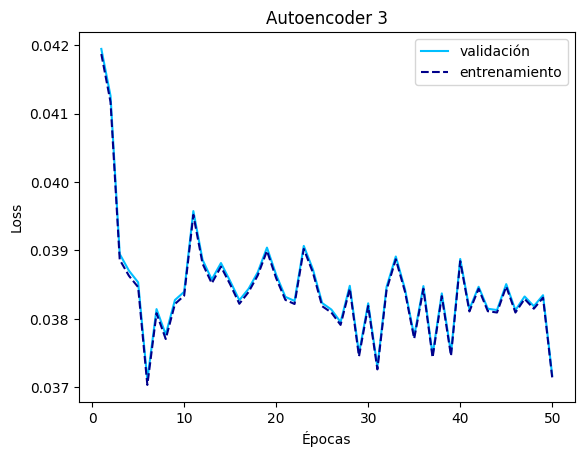

In [ ]:
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)


#plt.plot(range(1,len(list_train_avg_loss)+1),list_train_loss_cada_ej,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_SINL)+1),list_valid_loss_cada_ej_SINL,c='lightgreen')#,lw=0.5)


#plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1),list_train_avg_loss_incorrecta,label="train-incorr",linestyle='-',c='red')

plt.plot(range(1,len(list_valid_avg_loss)+1),list_valid_avg_loss,label="validación",linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="entrenamiento",linestyle='--',c='darkblue')

#plt.xlim(0,100)

plt.title('Autoencoder 3')

#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_autoencoder_juan_SINL_02_ADAM_50epoch.png", dpi =300)


plt.legend()

## grafico imagenes originales vs predichas

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

model = AutoencoderConv_SIN_LINEAL()
learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-3/modelo_SINL_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

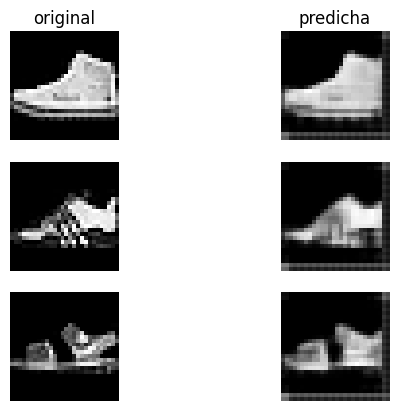

In [ ]:
model = model.to('cpu')

figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')

plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_prediccion_autoencoder_juan_SINL_02_ADAM_50epoch_4.png", dpi =300)

plt.show()

# *modelo rashka

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Reshape(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args

  def forward(self, x):
    return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self, *args):
    super().__init__()

  def forward(self, x):
    return x[:, :, :28, :28]


In [ ]:
#Ahora podemos definir nuestra red neuronal

class autoEncoder(nn.Module):
  def __init__(self,n):
    super().__init__()
    self.n = n
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.Flatten(),
        nn.Linear(3136, n)
    )


    self.convTrans = nn.Sequential(
        torch.nn.Linear(n, 3136),
        Reshape(-1, 64, 7, 7),
        nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
        Trim(),  # 1x29x29 -> 1x28x28
        nn.Sigmoid()
        )
  def forward(self, x):
    x = self.conv(x)
    x = self.convTrans(x)
    return x

# ---Entrenando autoencoder conv RASHKA n=64 p=0 ADAM

In [ ]:
n=64

model = autoEncoder(n)
model = model.to(device)

#print(model,device)

In [ ]:
# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.

num_epochs = 30

list_train_avg_loss_incorrecta_64 = []
list_train_avg_loss_64 = []
list_valid_avg_loss_64 = []
#list_train_precision_incorrecta = []
#list_train_precision = []
#list_valid_precision = []

list_train_loss_incorrecta_cada_ej_64 = []
list_train_loss_cada_ej_64 = []
list_valid_loss_cada_ej_64 = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta_64,train_loss_incorrecta_cada_ej_64 = train_loop(train_loader,model,loss_fn,optimizer)
    train_avg_loss_64,train_loss_cada_ej_64 = valid_loop(train_loader,model,loss_fn)
    valid_avg_loss_64,valid_loss_cada_ej_64 = valid_loop(valid_loader,model,loss_fn)

    list_train_avg_loss_incorrecta_64.append(train_avg_loss_incorrecta_64)
    list_train_avg_loss_64.append(train_avg_loss_64)
    list_valid_avg_loss_64.append(valid_avg_loss_64)

    list_train_loss_incorrecta_cada_ej_64.append(train_loss_incorrecta_cada_ej_64)
    list_train_loss_cada_ej_64.append(train_loss_cada_ej_64)
    list_valid_loss_cada_ej_64.append(valid_loss_cada_ej_64)

print("Done!")

Epoch 1
-------------------------------
avg_loss=0.011535
avg_loss=0.011628
Epoch 2
-------------------------------
avg_loss=0.008347
avg_loss=0.008455
Epoch 3
-------------------------------
avg_loss=0.006963
avg_loss=0.007071
Epoch 4
-------------------------------
avg_loss=0.006220
avg_loss=0.006339
Epoch 5
-------------------------------
avg_loss=0.005834
avg_loss=0.005966
Epoch 6
-------------------------------
avg_loss=0.005361
avg_loss=0.005502
Epoch 7
-------------------------------
avg_loss=0.005304
avg_loss=0.005452
Epoch 8
-------------------------------
avg_loss=0.005020
avg_loss=0.005181
Epoch 9
-------------------------------
avg_loss=0.004794
avg_loss=0.004971
Epoch 10
-------------------------------
avg_loss=0.004748
avg_loss=0.004942
Epoch 11
-------------------------------
avg_loss=0.004655
avg_loss=0.004863
Epoch 12
-------------------------------
avg_loss=0.004545
avg_loss=0.004766
Epoch 13
-------------------------------
avg_loss=0.004477
avg_loss=0.004707
Epoch 14

## guardo y cargo

In [ ]:
#aca guardo las listas con los loss para poder graficar

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_RASH64_ADAM_50epoch.npy', list_train_avg_loss_incorrecta_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_RASH64_ADAM_50epoch.npy', list_train_avg_loss_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_RASH64_ADAM_50epoch.npy', list_valid_avg_loss_64)

np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_RASH64_ADAM_50epoch.npy', list_train_loss_incorrecta_cada_ej_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_RASH64_ADAM_50epoch.npy', list_train_loss_cada_ej_64)
np.save('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_RASH64_ADAM_50epoch.npy', list_valid_loss_cada_ej_64)

In [ ]:
# Save the general checkpoint (luego de tener el modelo ya entrenado)

# Collect all relevant information and build your dictionary.


# Additional information
EPOCH = 50
PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_RASH64_ADAM_50epoch.pt'
LOSS = 0.054155

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

n=64

model =  autoEncoder(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_RASH64_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model = model.to(device)

In [ ]:
#64
list_train_avg_loss_incorrecta_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_RASH64_ADAM_50epoch.npy')
list_train_avg_loss_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_RASH64_ADAM_50epoch.npy')
list_valid_avg_loss_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_RASH64_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_RASH64_ADAM_50epoch.npy')
list_train_loss_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_RASH64_ADAM_50epoch.npy')
list_valid_loss_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_RASH64_ADAM_50epoch.npy')

## grafico loss

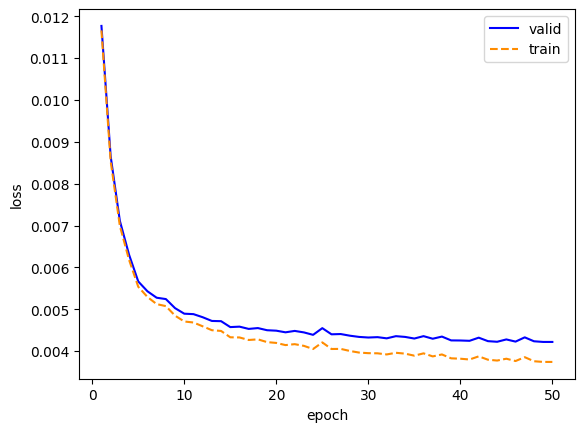

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)


#plt.plot(range(1,len(list_train_avg_loss)+1),list_train_loss_cada_ej,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_RASH64)+1),list_valid_loss_cada_ej_RASH64,c='lightgreen')#,lw=0.5)


#plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1),list_train_avg_loss_incorrecta,label="train-incorr",linestyle='-',c='red')

plt.plot(range(1,len(list_valid_avg_loss_RASH64)+1),list_valid_avg_loss_RASH64,label="valid",linestyle='-',c='blue')
plt.plot(range(1,len(list_train_avg_loss_RASH64)+1),list_train_avg_loss_RASH64,label="train",linestyle='--',c='darkorange')

#plt.xlim(0,100)

plt.title('')
plt.legend()

## grafico imagenes originales vs predichas

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

n=64

model =  autoEncoder(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-3/modelo_RASH64_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

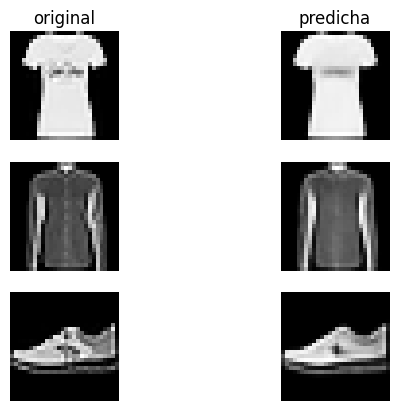

In [ ]:
model = model.to('cpu')

figure = plt.figure()
rows, cols = 3,2
i = 0 #subplot index

model.eval()

for row in range(1,rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  #graficamos imagen sin entrenar
  i += 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('original')
  plt.axis('off')
  plt.imshow(unbatch(image),cmap='Greys_r')
  #ploteamos imagen predicha
  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title('predicha')
  plt.axis('off')
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap='Greys_r')

#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_prediccion_autoencoder_RASH64_ADAM_50epoch_5.png", dpi =300)

plt.show()

In [ ]:
n=128

#model = Autoencoder_conv(n)
model = autoEncoder()
model = model.to(device)

print(model,device)

autoEncoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=64, bias=True)
  )
  (convTrans): Sequential(
    (0): Linear(in_features=64, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): Leaky

In [ ]:
# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.

num_epochs = 40

list_train_avg_loss_incorrecta_64 = []
list_train_avg_loss_64 = []
list_valid_avg_loss_64 = []
#list_train_precision_incorrecta = []
#list_train_precision = []
#list_valid_precision = []

list_train_loss_incorrecta_cada_ej_64 = []
list_train_loss_cada_ej_64 = []
list_valid_loss_cada_ej_64 = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta_64,train_loss_incorrecta_cada_ej_64 = train_loop(train_loader,model,loss_fn,optimizer)
    train_avg_loss_64,train_loss_cada_ej_64 = valid_loop(train_loader,model,loss_fn)
    valid_avg_loss_64,valid_loss_cada_ej_64 = valid_loop(valid_loader,model,loss_fn)

    list_train_avg_loss_incorrecta_64.append(train_avg_loss_incorrecta_64)
    list_train_avg_loss_64.append(train_avg_loss_64)
    list_valid_avg_loss_64.append(valid_avg_loss_64)

    list_train_loss_incorrecta_cada_ej_64.append(train_loss_incorrecta_cada_ej_64)
    list_train_loss_cada_ej_64.append(train_loss_cada_ej_64)
    list_valid_loss_cada_ej_64.append(valid_loss_cada_ej_64)

print("Done!")

Epoch 1
-------------------------------
avg_loss=0.011308
avg_loss=0.011403
Epoch 2
-------------------------------
avg_loss=0.008244
avg_loss=0.008352
Epoch 3
-------------------------------
avg_loss=0.006925
avg_loss=0.007039
Epoch 4
-------------------------------
avg_loss=0.006141
avg_loss=0.006256
Epoch 5
-------------------------------
avg_loss=0.005581
avg_loss=0.005708
Epoch 6
-------------------------------
avg_loss=0.005259
avg_loss=0.005394
Epoch 7
-------------------------------
avg_loss=0.005051
avg_loss=0.005198
Epoch 8
-------------------------------
avg_loss=0.004932
avg_loss=0.005091
Epoch 9
-------------------------------
avg_loss=0.004783
avg_loss=0.004957
Epoch 10
-------------------------------
avg_loss=0.004687
avg_loss=0.004870
Epoch 11
-------------------------------
avg_loss=0.004753
avg_loss=0.004946
Epoch 12
-------------------------------
avg_loss=0.004575
avg_loss=0.004780
Epoch 13
-------------------------------
avg_loss=0.004576
avg_loss=0.004791
Epoch 14

# CLASIFICADORES

In [ ]:
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

In [ ]:
class Clasificador_Conv1(nn.Module):
  def __init__(self,autoencoder_conv,n=64,p=0.2):
    super().__init__()
    self.n = 128
    self.p = 0.2
    self.encoder = autoencoder_conv.encoder

    #clasificador
    self.clasificador = nn.Sequential(
        nn.Linear(self.n,10),
        nn.ReLU(),
        nn.Dropout(self.p)
        )

  def forward(self,x):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

In [ ]:
class Clasificador_ConvRASH(nn.Module):
  def __init__(self,autoencoder_conv,n=64,p=0.2):
    super().__init__()
    self.n = 128
    #self.p = autoencoder_conv.p
    self.encoder = autoencoder_conv.conv

    #clasificador
    self.clasificador = nn.Sequential(
        nn.Linear(self.n,10),
        nn.ReLU(),
        nn.Dropout(self.p)
        )

  def forward(self,x):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

In [ ]:
# Definimos la función de entrenamiento
def train_loop2(dataloader,model,loss_fn,optimizer):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Copiamos las entradas y las salidas al dispositivo de trabajo
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_loss += loss_value
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            current = batch*len(X)
            print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    return avg_loss,precision

# 5.2)
# De manera similar, definimos la función de validación
def valid_loop2(dataloader,model,loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo
            X = X.to(device)
            y = y.to(device)
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_loss = sum_loss/num_batches
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss,precision

In [ ]:
# Creamos los DataLoaders
minibatch_size = 100    #tamaño minibatchs
train_loader_clasif = DataLoader(training_data_original, batch_size=minibatch_size,shuffle=True)
valid_loader_clasif = DataLoader(test_data_original, batch_size=minibatch_size,shuffle=True)

In [ ]:
len(train_loader_clasif), len(valid_loader_clasif) #el primero tiene 50 minibatchs de 1000 ejemplos, el segundo 10 minibatchs de 1000 ejemplos

(600, 100)

In [ ]:
len(train_loader_clasif.dataset)

60000

In [ ]:
# Creamos una instancia de una función de pérdida, (Mean Squared Error, MSE) en PyTorch, puedes utilizar la clase nn.MSELoss.

loss_fn = nn.MSELoss()

# ---entrenamos clasificador juan

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

n=64

model =  autoEncoder(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_RASH64_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model = model.to(device)

In [ ]:
Clasificador_Conv1

# --- entrenamos clasif rashka

In [ ]:
# Load the general checkpoint
# Remember to first initialize the model and optimizer, then load the dictionary locally.

n=128

model =  autoEncoder(n)

learning_rate = 1e-3 # necesario para definir
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

PATH = '/content/drive/MyDrive/archivos-redes/trabajo-final/modelo_RASH128_ADAM_50epoch.pt'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()        #You must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.
# - or -
#model.train()       #If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model = model.to(device)

RuntimeError: ignored

In [ ]:
print(model)

autoEncoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=64, bias=True)
  )
  (convTrans): Sequential(
    (0): Linear(in_features=64, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): Leaky

In [ ]:
n=64

modelo = Clasificador_ConvRASH(autoencoder_conv=model)
modelo = modelo.to(device)

#print(modelo,device)

TypeError: ignored

In [ ]:
# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(modelo.clasificador.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [ ]:
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 50
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision_incorrecta = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn)
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn)
    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision_incorrecta.append(train_precision_incorrecta)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print("Done!")

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)
plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1),list_train_avg_loss_incorrecta,label="train-incorr",linestyle='-',c='red')
plt.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="train",linestyle='-.',c='green')
plt.plot(range(1,len(list_valid_avg_loss)+1),list_valid_avg_loss,label="valid",linestyle='--',c='blue')
plt.title('')
plt.legend()

In [ ]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)
plt.plot(range(1,len(list_train_precision_incorrecta)+1),list_train_precision_incorrecta,label="train-incorrecta",linestyle='-',c='red')
plt.plot(range(1,len(list_train_precision)+1),list_train_precision,label="train",linestyle='-.',c='green')
plt.plot(range(1,len(list_valid_precision)+1),list_valid_precision,label="valid",linestyle='--',c='blue')
plt.title('')
plt.legend()

# grafico todos los rashka juntos

In [ ]:
##
list_train_avg_loss_incorrecta_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_RASH64_ADAM_50epoch.npy')
list_train_avg_loss_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_RASH64_ADAM_50epoch.npy')
list_valid_avg_loss_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_RASH64_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_RASH64_ADAM_50epoch.npy')
list_train_loss_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_RASH64_ADAM_50epoch.npy')
list_valid_loss_cada_ej_RASH64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_RASH64_ADAM_50epoch.npy')


##
list_train_avg_loss_incorrecta_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_RASH128_ADAM_50epoch.npy')
list_train_avg_loss_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_RASH128_ADAM_50epoch.npy')
list_valid_avg_loss_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_RASH128_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_RASH128_ADAM_50epoch.npy')
list_train_loss_cada_ej_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_RASH128_ADAM_50epoch.npy')
list_valid_loss_cada_ej_RASH128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_RASH128_ADAM_50epoch.npy')


##
list_train_avg_loss_incorrecta_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_RASH16_ADAM_50epoch.npy')
list_train_avg_loss_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_RASH16_ADAM_50epoch.npy')
list_valid_avg_loss_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_RASH16_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_RASH16_ADAM_50epoch.npy')
list_train_loss_cada_ej_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_RASH16_ADAM_50epoch.npy')
list_valid_loss_cada_ej_RASH16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_RASH16_ADAM_50epoch.npy')

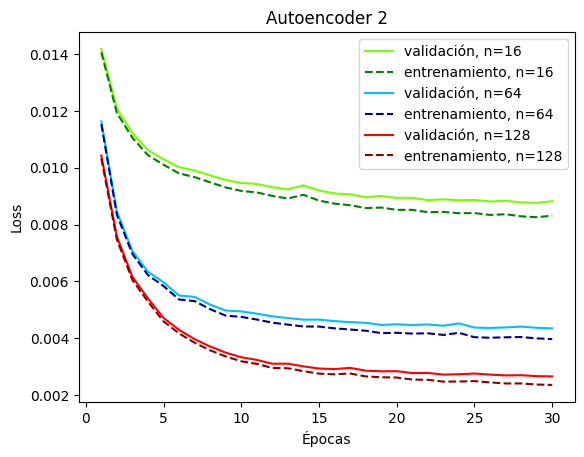

In [ ]:
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)



#plt.plot(range(1,len(list_train_avg_loss_RASH64)+1),list_train_loss_cada_ej_RASH16,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_RASH64)+1),list_valid_loss_cada_ej_RASH16,c='lightgreen')#,lw=0.5)

#plt.plot(range(1,len(list_train_avg_loss_RASH64)+1),list_train_loss_cada_ej_RASH64,c='lightblue')
#plt.plot(range(1,len(list_valid_loss_cada_ej_RASH64)+1),list_valid_loss_cada_ej_RASH64,c='lightblue')#,lw=0.5)

#plt.plot(range(1,len(list_train_avg_loss_RASH128)+1),list_train_loss_cada_ej_RASH128,c='lightpink')
#plt.plot(range(1,len(list_valid_loss_cada_ej_RASH128)+1),list_valid_loss_cada_ej_RASH128,c='lightpink')#,lw=0.5)


plt.plot(range(1,len(list_valid_avg_loss_RASH16)+1),list_valid_avg_loss_RASH16,label="validación, n=16",linestyle='-',c='lawngreen')
plt.plot(range(1,len(list_train_avg_loss_RASH16)+1),list_train_avg_loss_RASH16,label="entrenamiento, n=16",linestyle='--',c='green')

plt.plot(range(1,len(list_valid_avg_loss_RASH64)+1),list_valid_avg_loss_RASH64,label="validación, n=64",linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss_RASH64)+1),list_train_avg_loss_RASH64,label="entrenamiento, n=64",linestyle='--',c='darkblue')


plt.plot(range(1,len(list_valid_avg_loss_RASH128)+1),list_valid_avg_loss_RASH128,label="validación, n=128",linestyle='-',c='r')
plt.plot(range(1,len(list_train_avg_loss_RASH128)+1),list_train_avg_loss_RASH128,label="entrenamiento, n=128",linestyle='--',c='darkred')





#plt.plot(range(1,len(list_valid_avg_loss_512)+1),list_valid_avg_loss_512,label="valid",linestyle='-',c='blue')
#plt.plot(range(1,len(list_train_avg_loss_512)+1),list_train_avg_loss_512,label="train",linestyle='--',c='darkorange')

#plt.xlim(0,100)


plt.title('Autoencoder 2')


#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_todos_los_RASHKA.png", dpi =300)

plt.legend()

# grafico todos los juan juntos

In [ ]:
list_train_avg_loss_incorrecta_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_64_ADAM_50epoch.npy')
list_train_avg_loss_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_64_ADAM_50epoch.npy')
list_valid_avg_loss_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_64_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_64_ADAM_50epoch.npy')
list_train_loss_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_64_ADAM_50epoch.npy')
list_valid_loss_cada_ej_64 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_64_ADAM_50epoch.npy')



list_train_avg_loss_incorrecta_128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_128_ADAM_50epoch.npy')
list_train_avg_loss_128= np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_128_ADAM_50epoch.npy')
list_valid_avg_loss_128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_128_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_128_ADAM_50epoch.npy')
list_train_loss_cada_ej_128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_128_ADAM_50epoch.npy')
list_valid_loss_cada_ej_128 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_128_ADAM_50epoch.npy')



list_train_avg_loss_incorrecta_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_16_ADAM_50epoch.npy')
list_train_avg_loss_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_16_ADAM_50epoch.npy')
list_valid_avg_loss_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_16_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_16_ADAM_50epoch.npy')
list_train_loss_cada_ej_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_16_ADAM_50epoch.npy')
list_valid_loss_cada_ej_16 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_16_ADAM_50epoch.npy')

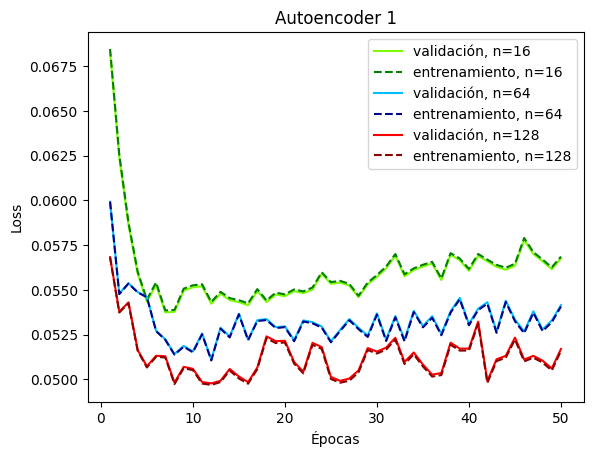

In [ ]:
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)


#plt.plot(range(1,len(list_train_avg_loss)+1),list_train_loss_cada_ej,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_512)+1),list_valid_loss_cada_ej_512,c='lightgreen')#,lw=0.5)


plt.plot(range(1,len(list_valid_avg_loss_16)+1),list_valid_avg_loss_16,label="validación, n=16",linestyle='-',c='lawngreen')
plt.plot(range(1,len(list_train_avg_loss_16)+1),list_train_avg_loss_16,label="entrenamiento, n=16",linestyle='--',c='green')

plt.plot(range(1,len(list_valid_avg_loss_64)+1),list_valid_avg_loss_64,label="validación, n=64",linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss_64)+1),list_train_avg_loss_64,label="entrenamiento, n=64",linestyle='--',c='darkblue')


plt.plot(range(1,len(list_valid_avg_loss_128)+1),list_valid_avg_loss_128,label="validación, n=128",linestyle='-',c='r')
plt.plot(range(1,len(list_train_avg_loss_128)+1),list_train_avg_loss_128,label="entrenamiento, n=128",linestyle='--',c='darkred')





#plt.plot(range(1,len(list_valid_avg_loss_512)+1),list_valid_avg_loss_512,label="valid",linestyle='-',c='blue')
#plt.plot(range(1,len(list_train_avg_loss_512)+1),list_train_avg_loss_512,label="train",linestyle='--',c='darkorange')

#plt.xlim(0,100)



plt.title('Autoencoder 1')


#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_todos_los_JUAN.png", dpi =300)


plt.legend()

# grafico todo todo junto

In [ ]:
list_train_avg_loss_incorrecta_SINL= np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_incorrecta_SINL_ADAM_50epoch.npy')
list_train_avg_loss_SINL = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_avg_loss_SINL_ADAM_50epoch.npy')
list_valid_avg_loss_SINL = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_avg_loss_SINL_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_SINL = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_incorrecta_cada_ej_SINL_ADAM_50epoch.npy')
list_train_loss_cada_ej_SINL = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_train_loss_cada_ej_SINL_ADAM_50epoch.npy')
list_valid_loss_cada_ej_SINL = np.load('/content/drive/MyDrive/archivos-redes/trabajo-final/list_valid_loss_cada_ej_SINL_ADAM_50epoch.npy')

In [ ]:
#512
list_train_avg_loss_incorrecta_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_train_avg_loss_incorrecta_512_ADAM_50epoch.npy')
list_train_avg_loss_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_train_avg_loss_512_ADAM_50epoch.npy')
list_valid_avg_loss_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_valid_avg_loss_512_ADAM_50epoch.npy')

list_train_loss_incorrecta_cada_ej_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_train_loss_incorrecta_cada_ej_512_ADAM_50epoch.npy')
list_train_loss_cada_ej_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_train_loss_cada_ej_512_ADAM_50epoch.npy')
list_valid_loss_cada_ej_512 = np.load('/content/drive/MyDrive/archivos-redes/trabajo-3/list_valid_loss_cada_ej_512_ADAM_50epoch.npy')

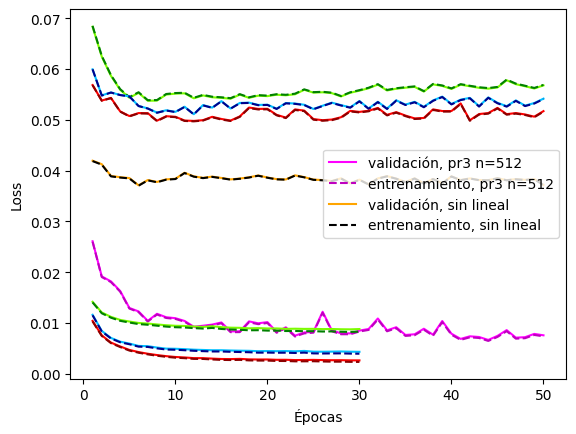

In [ ]:
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.xlim(-0.1,5.1)
#plt.ylim(-0.1,1.1)


#plt.plot(range(1,len(list_train_avg_loss)+1),list_train_loss_cada_ej,c='lightgreen')
#plt.plot(range(1,len(list_valid_loss_cada_ej_512)+1),list_valid_loss_cada_ej_512,c='lightgreen')#,lw=0.5)





plt.plot(range(1,len(list_valid_avg_loss_512)+1),list_valid_avg_loss_512,label="validación, pr3 n=512",linestyle='-',c='magenta')
plt.plot(range(1,len(list_train_avg_loss_512)+1),list_train_avg_loss_512,label="entrenamiento, pr3 n=512",linestyle='--',c='m')


plt.plot(range(1,len(list_valid_avg_loss_SINL)+1),list_valid_avg_loss_SINL,label="validación, sin lineal",linestyle='-',c='orange')
plt.plot(range(1,len(list_train_avg_loss_SINL)+1),list_train_avg_loss_SINL,label="entrenamiento, sin lineal",linestyle='--',c='black')




plt.plot(range(1,len(list_valid_avg_loss_RASH16)+1),list_valid_avg_loss_RASH16,linestyle='-',c='lawngreen')
plt.plot(range(1,len(list_train_avg_loss_RASH16)+1),list_train_avg_loss_RASH16,linestyle='--',c='green')

plt.plot(range(1,len(list_valid_avg_loss_RASH64)+1),list_valid_avg_loss_RASH64,linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss_RASH64)+1),list_train_avg_loss_RASH64,linestyle='--',c='darkblue')


plt.plot(range(1,len(list_valid_avg_loss_RASH128)+1),list_valid_avg_loss_RASH128,linestyle='-',c='r')
plt.plot(range(1,len(list_train_avg_loss_RASH128)+1),list_train_avg_loss_RASH128,linestyle='--',c='darkred')








plt.plot(range(1,len(list_valid_avg_loss_16)+1),list_valid_avg_loss_16,linestyle='-',c='lawngreen')
plt.plot(range(1,len(list_train_avg_loss_16)+1),list_train_avg_loss_16,linestyle='--',c='green')

plt.plot(range(1,len(list_valid_avg_loss_64)+1),list_valid_avg_loss_64,linestyle='-',c='deepskyblue')
plt.plot(range(1,len(list_train_avg_loss_64)+1),list_train_avg_loss_64,linestyle='--',c='darkblue')


plt.plot(range(1,len(list_valid_avg_loss_128)+1),list_valid_avg_loss_128,linestyle='-',c='r')
plt.plot(range(1,len(list_train_avg_loss_128)+1),list_train_avg_loss_128,linestyle='--',c='darkred')





#plt.plot(range(1,len(list_valid_avg_loss_512)+1),list_valid_avg_loss_512,label="valid",linestyle='-',c='blue')
#plt.plot(range(1,len(list_train_avg_loss_512)+1),list_train_avg_loss_512,label="train",linestyle='--',c='darkorange')

#plt.xlim(0,100)



plt.title('')


#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_TODOS.png", dpi =300)


plt.legend()

#plt.savefig("/content/drive/MyDrive/archivos-redes/trabajo-final/Grafico_TODOS.png", dpi =300)


plt.show()